In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import RobustScaler

In [2]:
# read train and test data
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

# merge all data in order to preprocess it
data_all = data_train.append(data_test)
data_all.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


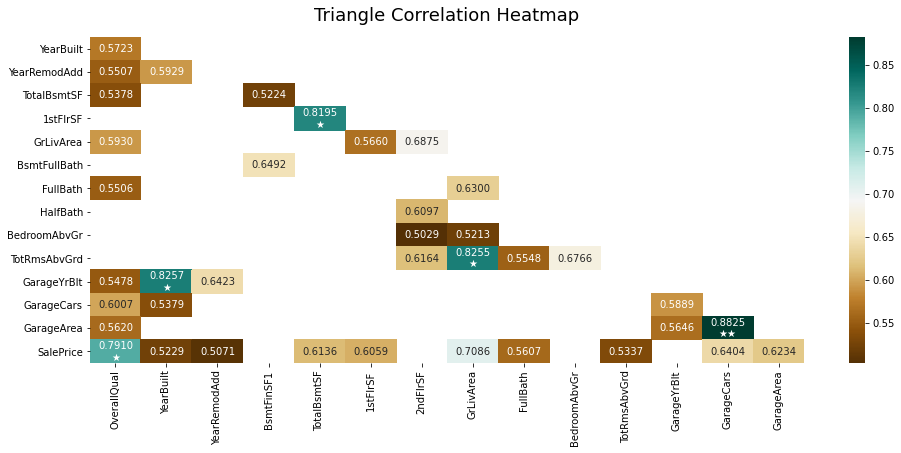

In [3]:
# Correlation heatmap restricted to interesting cells and add stars to mark exceptional values
plt.figure(figsize=(16, 6))
corr = data_train.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
# numpy .ones_like can create a matrix of booleans with the same shape as our data frame
# while .triu will return only the upper triangle of that matrix
cut_off = 0.5  # only show cells with abs(correlation) at least this value
extreme_1 = 0.75  # show with a star
extreme_2 = 0.85  # show with a second star
extreme_3 = 0.90  # show with a third star
mask |= np.abs(corr) < cut_off # the "|" would merge the two sets. The "|=" means "in-place OR"
corr = corr[~mask]  # fill in NaN in the non-desired cells. The "~" reverses the Bollean

remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n★')  # add one star if abs(val) >= extreme_1
          + ('' if abs(val) < extreme_2 else '★')  # add an extra star if abs(val) >= extreme_2
          + ('' if abs(val) < extreme_3 else '★')  # add yet an extra star if abs(val) >= extreme_3
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, annot=annot, fmt='', cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)
plt.show()

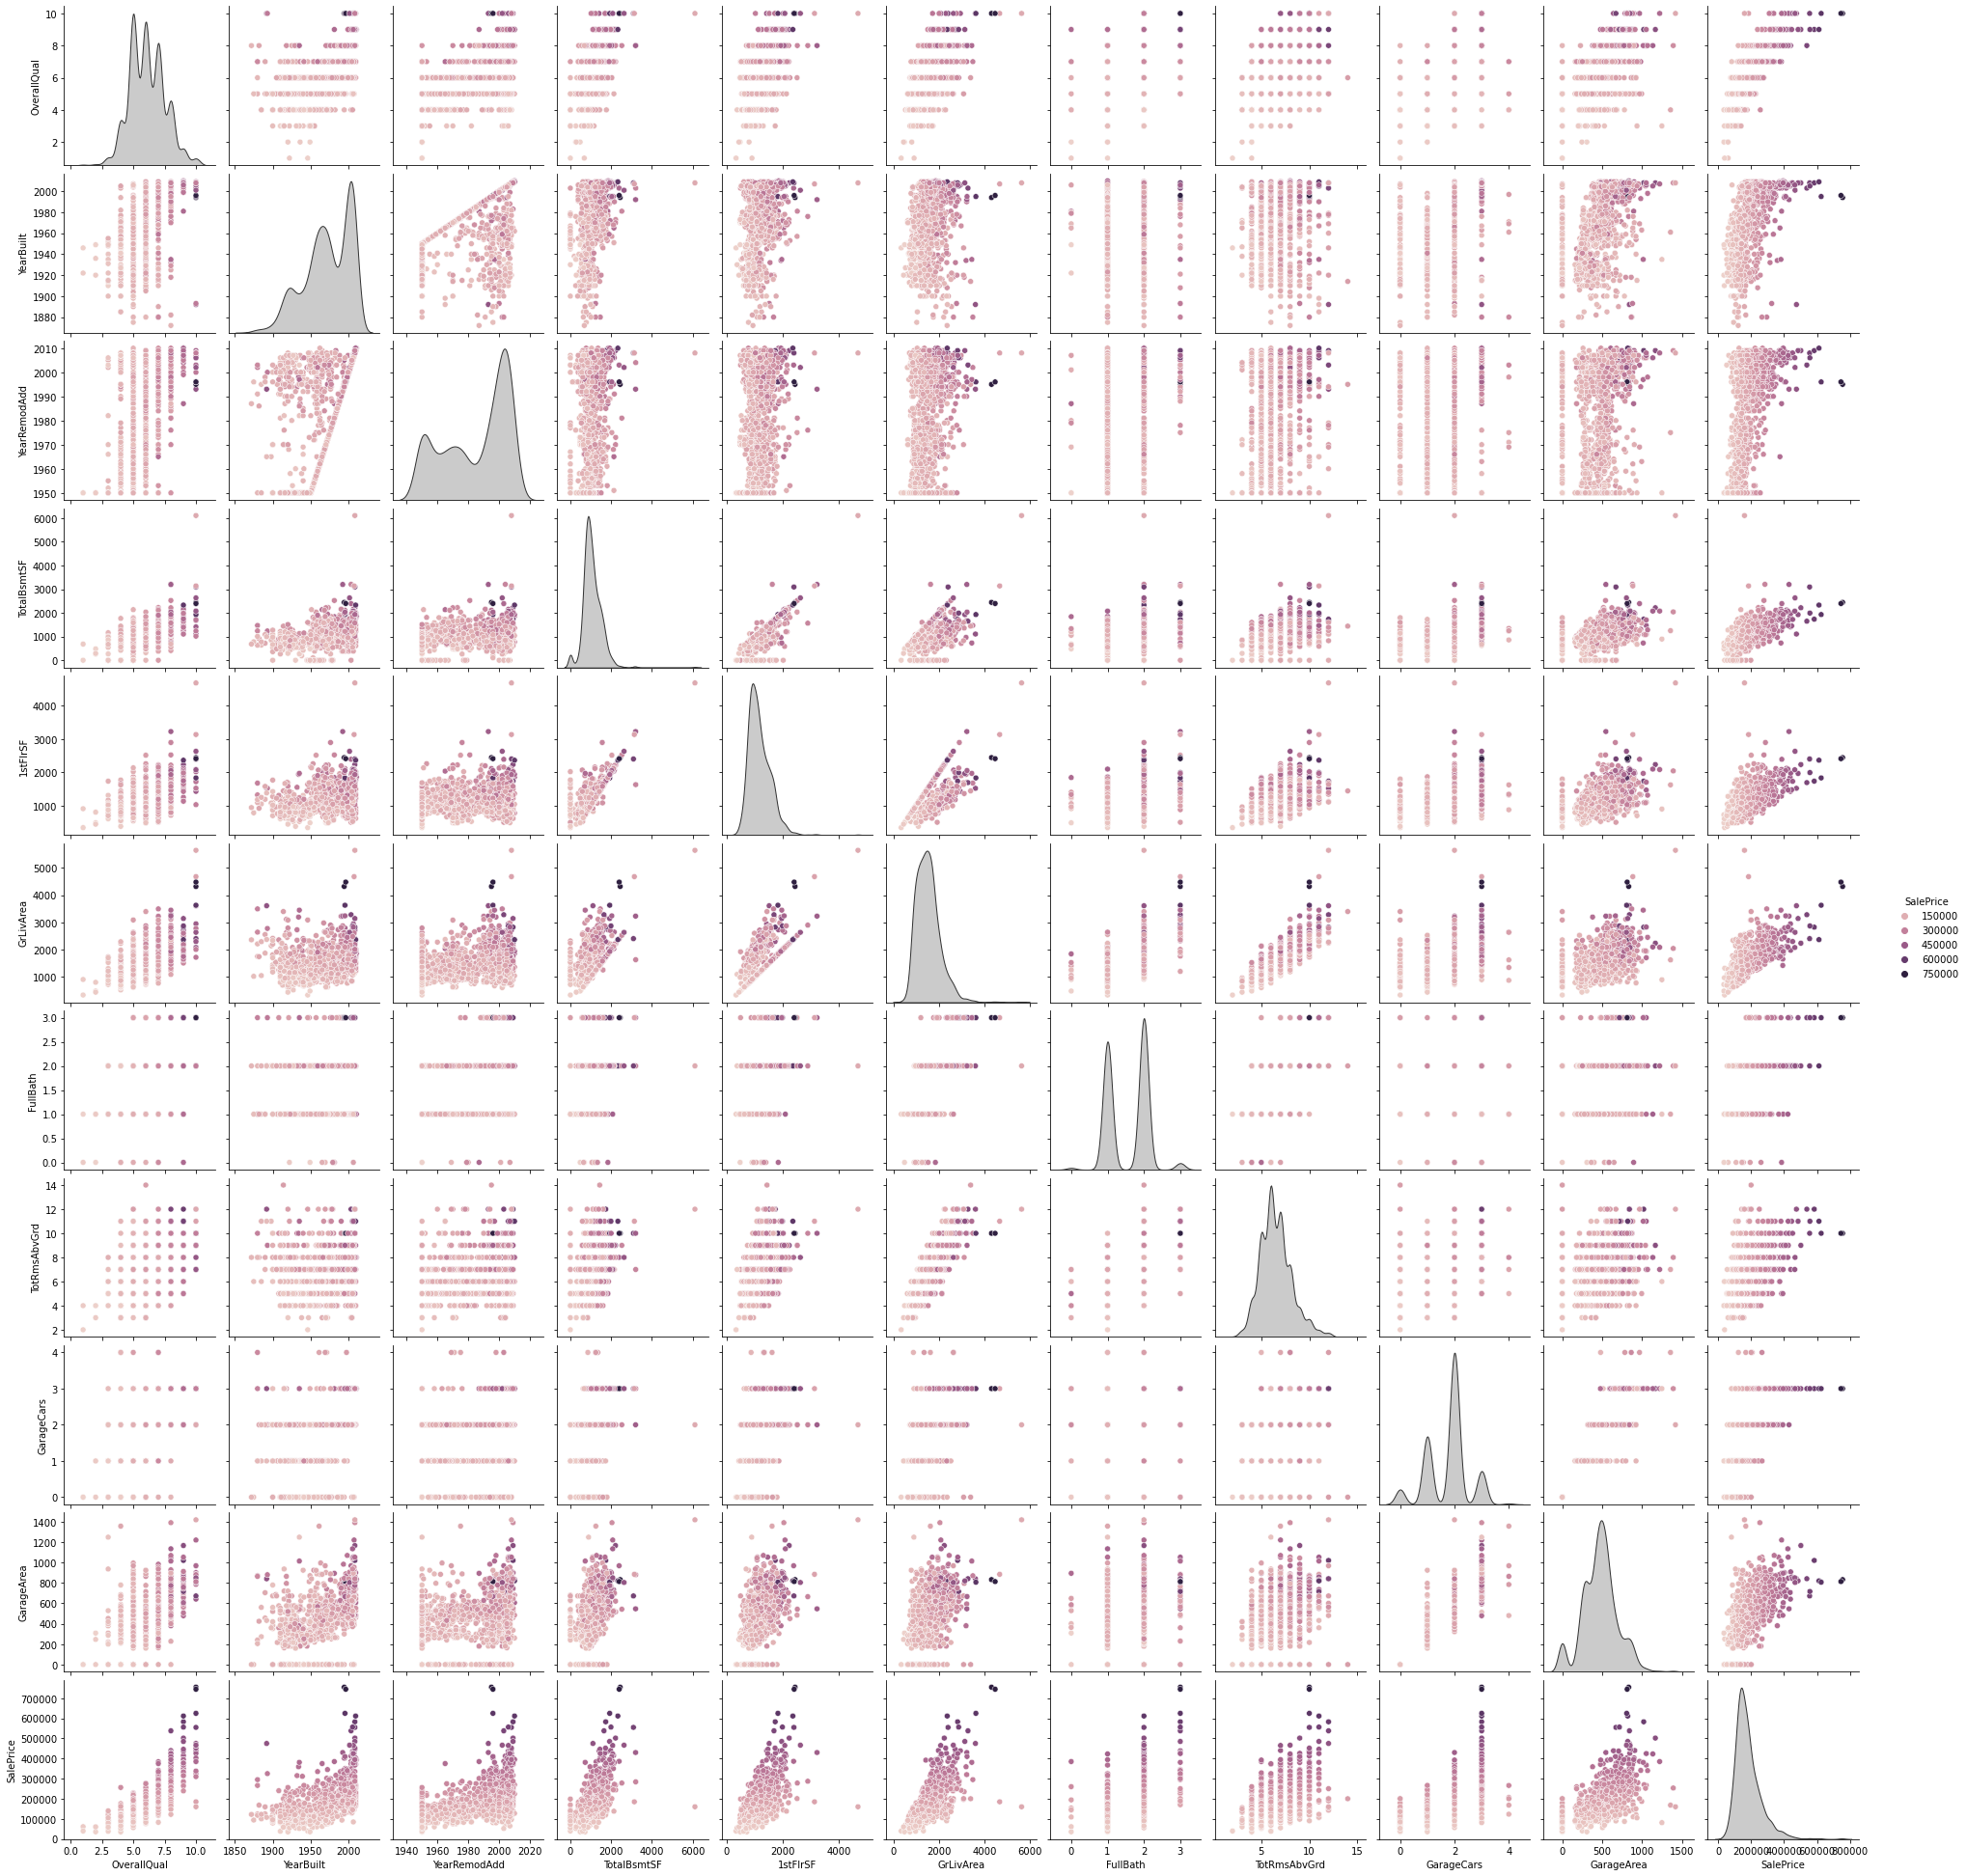

In [4]:
# Pair plot with the higher correlation features
sns.pairplot(data_train, hue = 'SalePrice', vars = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice'], diag_kws={"hue": None, "color": ".2"})

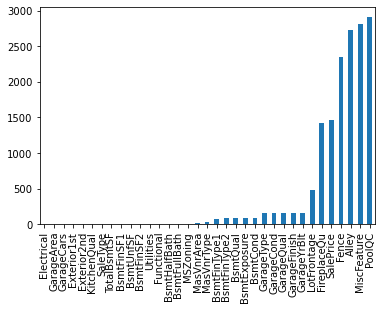

In [5]:
# missing data
data_all[data_all.columns[data_all.isna().sum() > 0]].isna().sum().sort_values().plot.bar();

In [6]:
# drop columns with too much data missing AND the target variable
drop_cols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage', 'SalePrice']
data_all.drop(drop_cols, inplace = True, axis=1)
data_all.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [7]:
# Identify features which are categorical
categorical = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LandSlope','Neighborhood','Condition1','Condition2',
               'BldgType','HouseStyle','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual',
               'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical', 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
               'BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd', 'Functional','Fireplaces','GarageType','GarageFinish',
               'GarageQual', 'GarageCond', 'PavedDrive','SaleType','SaleCondition','LotConfig'] #, 'GarageAgeCat'
# Categories
data_all[categorical] = data_all[categorical].astype('category')
# Encode categories to values
for item in categorical:
    data_all[item]=data_all[item].cat.codes

data_all.head()
#data_all.dtypes

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,5,3,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,2,0,3,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,3,5,3,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,4,6,3,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,5,5,3,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4


In [8]:
# Standarize scales taking care of outliers

columns_all = list(data_all.columns) # take all columns' labels
columns_all.pop(0) # remove 'Id' column from scaling

data_all[columns_all] = RobustScaler().fit_transform(data_all[columns_all])

data_all.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,0.166667,0.0,-0.245112,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.0,0.0,0.0,0.0,0.0,-1.00,0.0,0.0,0.0
1,2,-0.666667,0.0,0.035924,0.0,0.0,0.0,0.0,-1.0,0.0,...,-0.371429,0.0,0.0,0.0,0.0,0.0,-0.25,-0.5,0.0,0.0
2,3,0.166667,0.0,0.439150,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.228571,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0
3,4,0.333333,0.0,0.023705,0.0,-1.0,0.0,0.0,-2.0,0.0,...,0.128571,272.0,0.0,0.0,0.0,0.0,-1.00,-1.0,0.0,-4.0
4,5,0.166667,0.0,1.174731,0.0,-1.0,0.0,0.0,-1.0,0.0,...,0.828571,0.0,0.0,0.0,0.0,0.0,1.50,0.0,0.0,0.0


In [10]:
# Replace missing values by mean value
#data_all[data_all.columns[data_all.isna().sum() > 0]].isna().sum().sort_values().plot.bar();
for item in columns_all:
    data_all[item].loc[data_all[item].isnull()] = data_all[item].mean()


In [11]:
# split train and test data
train_data = data_all.iloc[0:len(data_train), :]
test_data = data_all.iloc[len(data_train):len(data_all), :]

#target variable
train_data_Y = data_train['SalePrice']

In [12]:
# Model

x = np.asanyarray(train_data)
y = np.asanyarray(train_data_Y)

xg_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 350, seed = 13, subsample = 0.9, learning_rate = 0.1, reg_alpha=0.001, reg_lambda = 10).fit(x,y)

# Prediction

y__xgb = xg_model.predict(test_data)

In [13]:
# Writing prediction to csv file
final = np.column_stack((data_test['Id'], y__xgb)) # put PassengerId and predTree in two columns

np.savetxt("result9.csv", final , delimiter=",", header="Id,SalePrice", fmt="%i", comments='')